In [1]:
import pandas as pd
import numpy as np

In [2]:
from math import asin,acos,atan 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
from skopt import gp_minimize

In [4]:
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from collections import OrderedDict
from sklearn.utils.random import check_random_state

In [5]:
import graphviz

In [26]:
def _arcsin(x):
  return np.arcsin(x)

arcsin= make_function(function=_arcsin,
                        name='arcsin',
                        arity=1)

In [27]:
def _arccos(x):
  return np.arccos(x)

arccos= make_function(function=_arccos,
                        name='arccos',
                        arity=1)

In [112]:
# def _exp(x):
#     with np.errstate(over='ignore'):
#        return np.exp(x)

# exp= make_function(function=_exp,
#                         name='exp',
#                         arity=1)

In [12]:
def _protected_exponent(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 100, np.exp(x), 0.)

exp= make_function(function=_protected_exponent,
                    name='exp',
                     arity=1)

In [13]:
exp(3)

array(20.08553692)

In [6]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 
                'inv','sin','cos','tan',
                'max', 'min']

function_set_s = [exp,'add', 'sub', 'mul', 'div',
                  'abs','inv','neg']

NameError: name 'exp' is not defined

In [15]:
df = pd.read_csv('/Users/jiayiluo/Dropbox/symbolic/simulations/symbolic_sim_1.csv', sep=',')

In [16]:
df.head()

,x1,y
0,1.017180,-1.551986
1,1.048455,-1.581402
2,0.943249,-1.428004
3,1.066828,-1.592297
4,1.126362,-1.595135


In [17]:
feature_names = ['x1']
target_name = 'y'

X = df[feature_names]
y = df[target_name]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [28]:
models = {'sr': SymbolicRegressor(population_size=200, init_method='half and half',
                           generations=60, stopping_criteria=0.001,
                           max_samples=0.9, verbose=1,
                           p_crossover=0.7,p_subtree_mutation=0.1,
                           p_hoist_mutation=0,p_point_mutation=0,
                           parsimony_coefficient=0.001, random_state=0,
                           function_set=function_set_s),
         'lm': make_pipeline(StandardScaler(), RidgeCV()),
         'rf': RandomForestRegressor()}

In [29]:
for model_name, model_instance in models.items():
    print('Training model {}'.format(model_name))
    model_instance.fit(X_train, y_train)

Training model sr
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.71      2.65644e+21        7         0.115872         0.124922      6.18s
   1     9.82           1.4463       23        0.0770526        0.0751971      4.15s
   2     9.81          19.3974        8        0.0731081        0.0710926      4.28s
   3     8.84          5.56845        8        0.0725403        0.0762035      3.83s
   4     6.32         0.885501        8        0.0724705        0.0768316      3.26s
   5     8.03          1.02175        8        0.0724344        0.0771564      3.58s
   6     8.56          1.48242        8        0.0724386        0.0771184      3.79s
   7     7.56          1.11214        3        0.0711697        0.0643195      3.52s
   8     7.03          1.56211        3        0.0700827 

In [ ]:
for model_name, model_instance in models.items():
    y_test_pred = model_instance.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    
    print('Model {}: \n mae: {} \n mse: {} \n'.format(model_name, mae, mse))

In [ ]:
print(models['sr']._program)

In [ ]:
dot_data = models['sr']._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
graph

In [ ]:
graph.render('/Users/jiayiluo/Dropbox/symbolic/simulations/simu_k.gv', view=True)

In [7]:
# Bayesian opt###
from sklearn.model_selection import cross_val_score

from skopt.space import Real, Integer,Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

In [ ]:
est_gp = SymbolicRegressor(population_size=200, init_method='grow',
                           generations=60, stopping_criteria=0.001,
                           max_samples=0.9, verbose=1,
                           p_crossover=0.7,p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1,p_point_mutation=0.1,
                           parsimony_coefficient="auto", random_state=0,
                           function_set=function_set)
est_gp.fit(X_train, y_train)

In [ ]:
est_gp=SymbolicRegressor( generations=60, stopping_criteria=0.01,
                           max_samples=0.9, verbose=1,
                           random_state=0,
                           function_set=function_set_s,
                           parsimony_coefficient=0.001)


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(100,2000,name='population_size'),
          Real(0, 0.7, name='p_crossover'),
          Real(0, 0.1, name='p_subtree_mutation'),
          Real(0, 0.1, name='p_hoist_mutation'),
          Real(0, 0.1, name='p_point_mutation'),
          Categorical(['grow', 'full', 'half and half'], name='init_method')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    est_gp.set_params(**params)

    return -np.mean(cross_val_score(est_gp, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [ ]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

In [24]:
res_gp.fun

1.696376372706254e-15

In [25]:
"Best score=%.4f" % res_gp.fun

'Best score=0.0000'

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

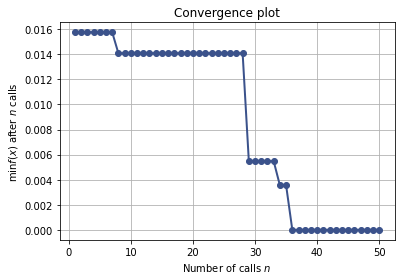

In [26]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [28]:
print((res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4],res_gp.x[5]))

(1034, 0.08104221150304239, 0.3053600083433693, 0.03828747760225982, 0.09295921815885919, 'grow')


In [29]:
est_gp_sep = SymbolicRegressor(population_size=1034,init_method='grow',
                           generations=60, stopping_criteria=0.001,
                           p_crossover=0.081, p_subtree_mutation=0.305,
                           p_hoist_mutation=0.038, p_point_mutation=0.093,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.001, random_state=0,
                           function_set=function_set_s)
est_gp_sep.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.48          25.6337        6        0.0459171         0.050674     39.06s
   1     8.25          1.36378        8         0.026476         0.027498     31.91s
   2     4.75         0.992938        8        0.0261517        0.0304171     26.72s
   3     3.80         0.766606        8        0.0259947        0.0318296     25.48s
   4     7.66         0.900399        9        0.0251744        0.0254578     27.69s
   5     8.32         0.528183        9        0.0200211        0.0204818     27.98s
   6     8.07          0.48517        9        0.0196931        0.0234335     27.98s
   7     8.29         0.514767        9        0.0196198        0.0240933     28.94s
   8     9.13         0.395261        9        0.0196571         0.023758  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'abs', 'inv', 'neg',
                                'log'],
                  generations=60, init_method='grow', max_samples=0.9,
                  p_crossover=0.081, p_hoist_mutation=0.038,
                  p_point_mutation=0.093, p_subtree_mutation=0.305,
                  population_size=1034, random_state=0, stopping_criteria=0.001,
                  verbose=1)

In [30]:
print(est_gp_sep._program)

sub(mul(0.433, abs(log(X0))), X0)


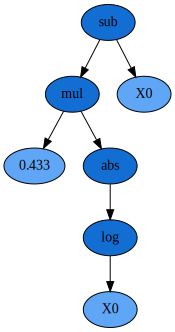

In [32]:
dot_data = est_gp_sep._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('/Users/jiayiluo/Dropbox/symbolic/simulations/simu_k_3.gv', view=False)
graph



In [ ]:
# import numpy as np
# score_gp = est_gp.score(X_test, y_test)

In [ ]:
# score_gp


In [179]:
df_2var= pd.read_csv('/Users/jiayiluo/Dropbox/symbolic/simulations/symbolic_sim_5_error1.csv', sep=',')

In [180]:
df_2var.head()

,k,tau,y
0,0.937013,0.353554,2.632769
1,1.081578,0.244240,2.964404
2,0.846053,0.443998,2.482988
3,1.023784,0.166379,2.766814
4,0.940237,0.133167,2.533744


In [181]:
feature_names = ['k','tau']
target_name = 'y'

X = df_2var[feature_names]
y = df_2var[target_name]


In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [183]:
X_train.head()


,k,tau
4884,0.954334,0.326708
3163,1.012696,0.442578
490,0.816412,0.243646
862,0.825353,0.151511
1740,0.888150,0.236486


In [184]:
y_train.head()

4884    2.659102
3163    2.904309
490     2.277154
862     2.261064
1740    2.441977
Name: y, dtype: float64

In [171]:
est_gp=SymbolicRegressor(generations=60, stopping_criteria=0.001,
                         max_samples=0.9, verbose=1,
                         random_state=0, parsimony_coefficient=0.002,
                         function_set=function_set_s)


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(200,2000,name='population_size'),
          Real(0, 0.15, name='p_crossover'),
          Real(0, 0.45, name='p_subtree_mutation'),
          Real(0, 0.25, name='p_hoist_mutation'),
          Real(0, 0.15, name='p_point_mutation'),
          Categorical(['grow', 'full', 'half and half'], name='init_method')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    est_gp.set_params(**params)

    return -np.mean(cross_val_score(est_gp, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [ ]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

In [173]:
res_gp.fun

0.0085799619436923

In [174]:
"Best score=%.4f" % res_gp.fun

'Best score=0.0086'

In [175]:
print((res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4],res_gp.x[5]))

(1410, 0.11712316047757504, 0.20066856171971129, 0.07948502951556595, 0.03459252692459266, 'half and half')


In [185]:
est_gp_sep=SymbolicRegressor(population_size=1410,init_method='half and half',
                            generations=60, stopping_criteria=0.002,
                            max_samples=0.9, verbose=1,
                            p_crossover=0.117, p_subtree_mutation=0.2,
                            p_hoist_mutation=0.079, p_point_mutation=0.035,
                            random_state=0, parsimony_coefficient=0.002,
                            function_set=function_set_s)
est_gp_sep.fit(X_train, y_train)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.20      2.03519e+38       18        0.0697401        0.0704613      1.15m
   1    10.92      1.50041e+37       18        0.0692129        0.0752066     48.29s
   2     4.95      5.07859e+37       18        0.0691579        0.0757014     40.27s
   3     2.57          6.59253        2        0.0786181        0.0913691     36.09s
   4     2.66          2.37217        2        0.0788291        0.0894702     35.82s
   5     2.52          5.11498        2        0.0787406         0.090266     34.54s
   6     2.50      8.67384e+36        2        0.0789565        0.0883232     34.27s
   7     2.70      4.25583e+16        2        0.0789092        0.0887489     33.98s
   8     2.59      2.78013e+37        2        0.0787901        0.0898206  

SymbolicRegressor(function_set=[<gplearn.functions._Function object at 0x7f8f80717610>,
                                'add', 'sub', 'mul', 'div', 'abs', 'inv',
                                'neg'],
                  generations=60, max_samples=0.9, p_crossover=0.117,
                  p_hoist_mutation=0.079, p_point_mutation=0.035,
                  p_subtree_mutation=0.2, parsimony_coefficient=0.002,
                  population_size=1410, random_state=0, stopping_criteria=0.002,
                  verbose=1)

In [186]:
print(est_gp_sep._program)

add(add(sub(add(X0, X1), inv(0.997)), div(exp(-0.452), add(X0, X1))), add(X0, X0))


In [187]:
#est_gp_new._program=mul(sub(sub(sub(mul(3,X0),mul(2.228,X1)),1.34),div(X1,X0)),div(add(X0, mul(1.228,X1)),add(X1, 0.248)))

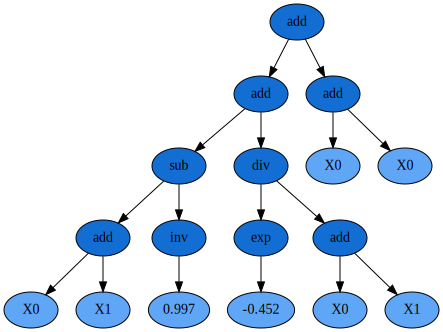

In [188]:
dot_data = est_gp_sep._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph.render('/Users/jiayiluo/Dropbox/symbolic/simulations/image_sim_5_error1', format='png', cleanup=True)
graph


In [19]:
models = {'sr': SymbolicRegressor(population_size=435,init_method='half and half',
                            generations=60, stopping_criteria=0.001,
                            max_samples=0.9, verbose=1,
                            p_crossover=0.032, p_subtree_mutation=0.237,
                            p_hoist_mutation=0.194, p_point_mutation=0.02,
                            random_state=0, parsimony_coefficient=0.0005,
                            function_set=function_set_s),
         'lm': make_pipeline(StandardScaler(), RidgeCV()),
         'rf': RandomForestRegressor()}

In [20]:
for model_name, model_instance in models.items():
    print('Training model {}'.format(model_name))
    model_instance.fit(X_train, y_train)

Training model sr
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.34          23.1964        3        0.0951537        0.0837758     17.50s
   1     9.94          1.17725        4        0.0928385         0.103402     14.11s
   2     5.12         0.785236        1        0.0921236         0.111047     11.39s
   3     3.51         0.799572        3        0.0925476         0.107231     10.53s
   4     2.96         0.494022        3        0.0923526         0.108986     10.05s
   5     1.97         0.475918        1        0.0921417         0.110884      9.91s
   6     2.05          1.00902        1        0.0924679         0.107949     12.24s
   7     1.82         0.535534        1        0.0918029         0.113933      9.33s
   8     2.05         0.676394        1        0.0915069 

In [21]:
for model_name, model_instance in models.items():
    y_test_pred = model_instance.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    
    print('Model {}: \n mae: {} \n mse: {} \n'.format(model_name, mae, mse))

Model sr: 
 mae: 0.03715134056216754 
 mse: 0.007597649850242908 

Model lm: 
 mae: 0.06612426328539411 
 mse: 0.014053640316234 

Model rf: 
 mae: 0.003026327704555201 
 mse: 0.00014851693857573703 



In [ ]:
models = {'sr': est_gp,
         'dt': est_tree,
         'rf': est_rf}

for model_name, model_instance in models.items():
    y_test_pred = model_instance.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    
    print('Model {}: \n mae: {} \n mse: {} \n'.format(model_name, mae, mse))

In [ ]:
print(est_gp._program)

In [ ]:
X_train.head()

In [ ]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

# Training samples
X_train = np.random.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = np.random.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1


In [ ]:
y_train.print()